Importing the required libraries and packages

In [1]:
# importing required packages and libraries
from PIL import Image
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn
import mxnet as mx
import numpy as np
import pandas as pd
import time
from mxnet import profiler
import re
import matplotlib.pyplot as plt
data_ctx = mx.gpu()
model_ctx = mx.gpu()

In [2]:
# setting the profiler for measuring the execution time and memory usage
profiler.set_config(profile_all=False,profile_symbolic=False,profile_imperative=False, profile_memory=True, profile_api=True,aggregate_stats=True,continuous_dump=False, filename='mean_shift_gpu_profile.json')


Loading image and pre-processing

In [3]:
# loading the image to be used using pillow
img = Image.open('peppers.png').resize((200, 150))
print(img)


<PIL.Image.Image image mode=RGB size=200x150 at 0x196C4E73CC0>


In [4]:
# converting the image to numpy array
image = np.array(img)

In [5]:
# converting the numpy image to mxnet array
mx_image = mx.nd.array(image).copyto(data_ctx)
mx_image = mx_image.astype('float32')/255

In [6]:
# getting the dimensions of the image and setting hyperparameters
width = mx_image.shape[0]
height = mx_image.shape[1]
colors = mx_image.shape[2]
num_of_epochs = 10
bandwidth = 0.1

(150, 200, 3)


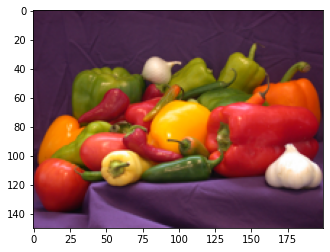

In [7]:
print(mx_image.shape)
plt.figure()
plt.imshow(mx_image.asnumpy())
plt.show()

Training the model

In [8]:
mx.nd.waitall() 

# starting the profiler
profiler.set_state('run')
start = time.time()

In [9]:
# training 
mx_image2 = mx_image.copyto(data_ctx)
for epoch in range(num_of_epochs):
    for w in range(width):
        for h in range(height):
            k = mx.nd.exp(mx.nd.sum(-mx.nd.square((mx_image[w,h] - mx_image)/bandwidth), axis = 2))
            a = mx.nd.sum((mx_image-mx_image[w,h])*k.reshape(width, height, 1), axis=(0,1))
            b = mx.nd.sum(k, axis=(0,1))
            mx_image2[w,h] = mx_image[w,h] + a/b
    mx_image = mx_image2.copyto(data_ctx)

In [10]:
# waiting for all operations to end, then stopping the profiler
mx.nd.waitall()
end = time.time()
profiler.set_state('stop')

In [11]:
results = profiler.dumps()

In [12]:
result = results
result = result.split('\n')

In [13]:
# splitting the result into a list of lists
for i in range(len(result)):
    result[i] = result[i].split()

In [14]:
# extracting the maximum gpu and cpu memory usage and the total execution time
max_gpu_use = 0
max_cpu_use = 0
total_execution_time = 0
# traversing over the lists and trying to find the maximum gpu and cpu memory usage and the total execution time
for i in result:
    if (len(i)>=1 and i[0]=='Memory:'):
        if (i[1]=='gpu/0'):
            max_gpu_use = float(i[-2])
        elif (i[1]=='cpu/0'):
            max_cpu_use = float(i[-2])
        else: continue
    # if the length of the list 6 and the second to sixth elements are numbers, then it is a time entry
    else:
        if (len(i)>=6):
            # if it is a valid time entry, then add it to the total execution time
            if (re.match(r'^-?\d+(?:\.\d+)$', i[-4]) is not None):
                total_execution_time += float(i[-4])

if (total_execution_time==0):
    total_execution_time = (end - start)*1000

In [15]:
print(f"Maximum GPU memory usage: {max_gpu_use} KB")
print(f"Maximum CPU memory usage: {max_cpu_use} KB")
print(f"Total execution time: {total_execution_time} milli seconds (ms)")

Maximum GPU memory usage: 2040.0 KB
Maximum CPU memory usage: 0 KB
Total execution time: 1138539.333820343 milli seconds (ms)


(150, 200, 3)


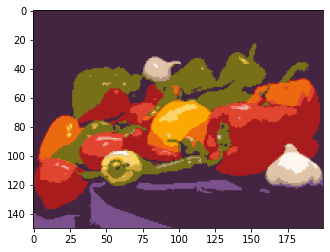

In [16]:
print(mx_image.shape)
plt.figure()
plt.imshow(mx_image.asnumpy())
plt.show()